<a href="https://colab.research.google.com/github/camilodlt/rtidy-python/blob/main/Computer%20vision/CIFAR/Customize_a_sequential_AutoML_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Customizing a Sequential AutoML Pipeline**


In this notebook, we will implement a pipeline to handle the image classification on the Cifar 10 dataset. 

1. Load and prepare cifar10 dataset
3. Build a sequential AutoML pipeline
3. Explore the searched model
4. Retrain and evaluate searched model

In [ ]:
%%capture
!pip install tensorflow==2.3.0
!pip install autokeras==1.0.16
!pip install keras_tuner==1.0.3


In [ ]:
import keras_tuner
keras_tuner.__version__

'1.0.3'

In [ ]:
# import the python packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow import keras

import autokeras as ak

print( "tf.__version__:", tf.__version__ )
print( "ak.__version__:", ak.__version__ )

tf.__version__: 2.3.0
ak.__version__: 1.0.16


In [ ]:
!nvidia-smi

Thu Sep 16 06:27:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

import tensorflow as tf 
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load dataset

#### Prepare data

In [ ]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = x_train.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)
print('Training image shape:', x_train.shape)
print('Training label shape:', y_train.shape)
print('Testing image shape:', x_test.shape)
print('Testing label shape:', y_test.shape)

Training image shape: (50000, 32, 32, 3)
Training label shape: (50000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)


In [ ]:
# Sample the Dataset ------
from sklearn.utils import resample
x_train_sampled, y_train_sampled = resample(x_train, y_train, n_samples=10000, replace=False, random_state=0)

print('Training image shape:', x_train_sampled.shape)
print('Training label shape:', y_train_sampled.shape)
print('Testing image shape:', x_test.shape)
print('Testing label shape:', y_test.shape)

Training image shape: (10000, 32, 32, 3)
Training label shape: (10000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)


## Build a sequential AutoML pipeline

#### Build sequential model with Functional API

In [ ]:
hp = keras_tuner.HyperParameters()
num_blocks=keras_tuner.engine.hyperparameters.Choice("num_blocks",values=[2])
num_layers=keras_tuner.engine.hyperparameters.Choice("num_layers",values=[1])

inputs = ak.ImageInput()
x = ak.Normalization()(inputs)
x = ak.ImageAugmentation()(x)
# Build a sequential AutoML pipeline using multiple AutoKeras built-in blocks(ak.ConvBlock).
x = ak.ConvBlock(num_blocks=num_blocks,
                 num_layers=num_layers,
                 name= "CNN1")(x) 
x = ak.ConvBlock(num_blocks=num_blocks,
                 num_layers=num_layers,
                 name= "CNN2")(x) 
x = ak.ConvBlock(num_blocks=num_blocks,
                 num_layers=num_layers,
                 name= "CNN3")(x) 

outputs = ak.ClassificationHead(dropout=0.0)(x)

#### Search pipelines

In [ ]:
clf = ak.AutoModel(
    inputs=inputs, 
    outputs=outputs,
    project_name= "Pipeline_1",
    max_trials=10,
    overwrite=True,
    objective= "val_accuracy")

clf.fit(x_train_sampled, y_train_sampled, epochs=20) # ,epochs=3, verbose=2

Trial 10 Complete [00h 00m 51s]
val_accuracy: 0.5309959053993225

Best val_accuracy So Far: 0.5609756112098694
Total elapsed time: 00h 08m 07s
INFO:tensorflow:Oracle triggered exit
Epoch 1/20
313/313 [==============================] - 2s 7ms/step - loss: 2.1454 - accuracy: 0.1665
Epoch 2/20
313/313 [==============================] - 2s 6ms/step - loss: 1.9196 - accuracy: 0.2447
Epoch 3/20
313/313 [==============================] - 2s 6ms/step - loss: 1.7953 - accuracy: 0.3025
Epoch 4/20
313/313 [==============================] - 2s 6ms/step - loss: 1.7234 - accuracy: 0.3299
Epoch 5/20
313/313 [==============================] - 2s 6ms/step - loss: 1.6664 - accuracy: 0.3565
Epoch 6/20
313/313 [==============================] - 2s 7ms/step - loss: 1.5990 - accuracy: 0.3814
Epoch 7/20
313/313 [==============================] - 2s 6ms/step - loss: 1.5521 - accuracy: 0.4021
Epoch 8/20
313/313 [==============================] - 2s 6ms/step - loss: 1.4928 - accuracy: 0.4376
Epoch 9/20
313/313 

## Explore Model

In [ ]:
# Get the summarized results during the tuning process (return the best 10 models if existed)
clf.tuner.results_summary()

Results summary
Results in ./Pipeline_1
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
image_augmentation_1/translation_factor: 0.0
image_augmentation_1/horizontal_flip: True
image_augmentation_1/vertical_flip: True
image_augmentation_1/rotation_factor: 0.0
image_augmentation_1/zoom_factor: 0.0
image_augmentation_1/contrast_factor: 0.0
CNN1/kernel_size: 3
CNN1/separable: False
CNN1/max_pooling: True
CNN1/dropout: 0
CNN1/num_blocks: 2
CNN1/num_layers: 1
CNN1/filters_0_0: 32
CNN1/filters_1_0: 256
CNN2/kernel_size: 7
CNN2/separable: False
CNN2/max_pooling: True
CNN2/dropout: 0
CNN2/num_blocks: 2
CNN2/num_layers: 1
CNN2/filters_0_0: 32
CNN2/filters_1_0: 32
CNN3/kernel_size: 3
CNN3/separable: False
CNN3/max_pooling: True
CNN3/dropout: 0.25
CNN3/num_blocks: 2
CNN3/num_layers: 1
CNN3/filters_0_0: 32
CNN3/filters_1_0: 32
classification_head_1/spatial_reduction_1/reduction_type: flatten
optimizer: adam
learning_rate: 0.001
Score: 0.56097561

Since it's a little long let's only see the best model. 

In [ ]:
#Retrieve best model
best_model = clf.export_model()
best_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 32, 32, 3)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 3)         7         
_________________________________________________________________
random_flip (RandomFlip)     (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 256)      

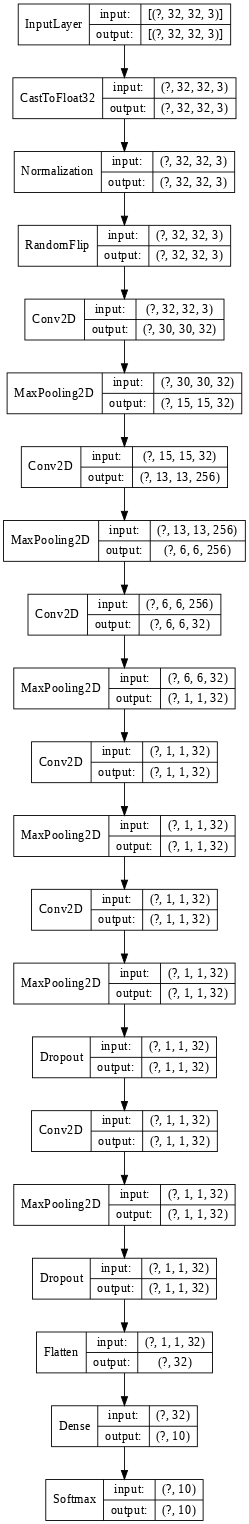

In [ ]:
# Converts a Keras model to dot format and plot an image
tf.keras.utils.plot_model(best_model, show_layer_names=False, show_shapes=True, expand_nested=True, dpi=64)

## Retrain and evaluate searched model

In [ ]:
# compile the model and train the model
best_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

best_model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.10)

Epoch 1/20
704/704 [==============================] - 5s 7ms/step - loss: 1.2363 - accuracy: 0.5618 - val_loss: 1.1023 - val_accuracy: 0.6056
Epoch 2/20
704/704 [==============================] - 5s 7ms/step - loss: 1.1683 - accuracy: 0.5915 - val_loss: 1.0706 - val_accuracy: 0.6188
Epoch 3/20
704/704 [==============================] - 5s 7ms/step - loss: 1.1184 - accuracy: 0.6116 - val_loss: 1.0249 - val_accuracy: 0.6292
Epoch 4/20
704/704 [==============================] - 5s 7ms/step - loss: 1.0781 - accuracy: 0.6254 - val_loss: 1.0088 - val_accuracy: 0.6462
Epoch 5/20
704/704 [==============================] - 5s 7ms/step - loss: 1.0413 - accuracy: 0.6421 - val_loss: 1.0159 - val_accuracy: 0.6436
Epoch 6/20
704/704 [==============================] - 5s 7ms/step - loss: 1.0034 - accuracy: 0.6544 - val_loss: 0.9564 - val_accuracy: 0.6592
Epoch 7/20
704/704 [==============================] - 5s 7ms/step - loss: 0.9794 - accuracy: 0.6648 - val_loss: 0.9642 - val_accuracy: 0.6572
Epoch 

In [ ]:
init= 20

In [ ]:
best_model.fit(x_train, y_train, epochs=init+2, batch_size=64, validation_split=0.10, initial_epoch=init)
init+=2

Epoch 21/22
704/704 [==============================] - 5s 7ms/step - loss: 0.7256 - accuracy: 0.7537 - val_loss: 0.8858 - val_accuracy: 0.7024
Epoch 22/22
704/704 [==============================] - 5s 7ms/step - loss: 0.7165 - accuracy: 0.7553 - val_loss: 0.9007 - val_accuracy: 0.6932


It already started overfitting.

#### Evaluate the searched model

In [ ]:
# evaluate the model
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=1)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.9269 - accuracy: 0.6905
Test loss:  0.9268772602081299
Test accuracy:  0.690500020980835
